In [1]:
# Package utilisé
# pytorch : https://pytorch.org/
# numpy : https://numpy.org/
# matplotlib : https://matplotlib.org/
# pandas : https://pandas.pydata.org/
# scikit-learn : https://scikit-learn.org/stable/
! pip install torch numpy matplotlib pandas

In [ ]:
# from importlib.metadata import version
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
# from matplotlib import pyplot as plt
# import time
# import os

# Pour torch si vous avez un GPU
# device = "cpu" if not torch.cuda.is_available() else "cuda"
device = "cpu" # Pour forcer l'utilisation du CPU


In [3]:
# Environement potentielement testé
from environnement.environnement import Environnement as env # mother class
from environnement.environnement1 import Environnement1 as env1
from environnement.environnement2Str import Environnement2 as env2Str
from environnement.environnement3Str import Environnement3 as env3Str
from environnement.environnement6Str import Environnement6 as env6Str
from environnement.small_loop import small_loop

# model machine learning
from model.DeepNN import *
from model.Tokenizer import *
from outil import *

# L'agent qui prédit l'avenir
Dans ce notebook nous allons implémenter un agent dévellopementale qui aura comme simple but de prédire le prochain feedback de son environement.

## Mécanisme de prédiction
Dans se notebook nous allons implémenté deux mécanismes de machine learning, un decision tree et un deep neural network. L'entrainement des deux modèls se fera sur la "vie" de l'agent. C'est à dire que les modèls s'entrainerons seulement sur les interactions que l'agents aura faites.

# Définition de l'agent

In [ ]:
class Agent1:
    def __init__(self, model, all_outcomes, all_actions, tokenizer, optimizer=None, loss_func=None):
        """ 
        Création de l'agent.
        from importlib.metadata import from importlib.metadata import version importlib.metadata import versionversion
        - self._action : action précédente
        - self._predicted_outcome : prédiction de l'outcome précédent
        """
        self._action = None
        self._predicted_outcome = None
        self._model = model
        self._otimizer = optimizer
        self._loss_func = loss_func
        self._tokenizer:SimpleTokenizerV1 = tokenizer
        self._all_outcomes = all_outcomes
        self._all_actions = all_actions

    def fit(self, action, outcome, validate_loader=None):
        """
        Fonction d'entrainement de l'agent
        """
        action = self._tokenizer.encode(action)
        outcome = self._tokenizer.encode(outcome)
        try:
            self._model.train()
            action = torch.tensor([action], dtype=torch.float).to(device)
            outcome = torch.tensor(outcome, dtype=torch.long).to(device)
            outcome = torch.nn.functional.one_hot(outcome, 
                num_classes=len(self._all_outcomes)).to(torch.float)
            train(model=self._model, 
                    train_data=[(action, outcome)],
                    optimizer=self._otimizer,
                    loss_func=self._loss_func,
                    nb_epochs=1,
                    validate_loader=validate_loader,
                    print_=True)
        except Exception as e: # Si le model n'est pas un model pytorch
            raise Exception('Not implemented')
            self._model.fit(action, outcome)
            pass
       

    def predict(self, action):
        """
        Funciton de prédiction
        """
        action = self._tokenizer.encode(action)
        try: # Si le model est un model pytorch
            self._model.eval() # On peut le passer en mode evaluation
            # On prépare notre jeu de donnée, qui consite en 
            # la dernière action et l'outcome de la dernière interaction 
            action = torch.tensor([action], dtype=torch.float).to(device)
            x = self._model(action)
            x = torch.argmax(x, dim=0).item()

        except: # Si le model n'est pas un model pytorch
            raise Exception('Not implemented')
            x=self._model.predict(action)
        
        return self._tokenizer.decode(x)

    def action(self, _outcome, fit=True, validate_loader=None):
        """ 
        Fonction qui choisit l'action a faire en fonction de la dernière \
        intéraction avec l'environnement. \n
        C'est ici que nous allons implémenter un mécanisme de ML \
        pour choisir la prochaine action.

        :param: **_outcome** feedback de la dernière intéraction avec l'environnement

        :return: **action** action à effectuer
        """
        if self._action is not None:
            print(f"Action: {self._action}, Prediction: {self._predicted_outcome}, Outcome: {_outcome}, " 
                  f"\033[0;31m Satisfaction: {self._predicted_outcome == _outcome} \033[0m")
            # Nous entrainons le model sur la dernière action et son outcome
            if fit:
                self.fit(self._action, _outcome, validate_loader)
            # Nous faisons une prédiction sur une action aléatoire
            self._action = np.random.choice(self._all_actions)
            self._predicted_outcome = self.predict(self._action)
        else:
            # Au début de la vie de l'agent, nous prennons la première action possible
            self._action = self._all_actions[0]
            self._predicted_outcome = self.predict(self._action)
            print(f"Action de base : {self._action} Prediction: {self._predicted_outcome}")
        
        return self._action, self._predicted_outcome

# Deep neural network
Nous allons utiliser un DNN, il a besoin d'une dimension d'entrée et de sortie. De plus plus nous pouvons ajouter des couches caché.
Les principe d'un Neural Network est de renvoyé un vecteur de taille _dimension sortie_, a partir d'un vecteur  Dans ce vecteur le Neural Network va prédire un certain chiffre, ce chiffre est ensuite normalisé pour donner une probablité.

## Comment associé un DNN avec un agent dévellopemental ?
L'idée derrière un agent dévellopemental est que l'agent enact un comportement à partir des interactions qu'il a eu avec son environnement. Il y a deux spésificités, l'agent ne recoit de l'environemment qu'un simple feedback ou outcome. Et nous voulons qu'il comprenne cette environement qu'avec une 'vie' soit un nombre très petit d'interaction. L'idée d'utiliser un modèl de ML est de dévélopper un modèl en l'entrainant petit à petit sur chaque interactions qu'il va faire 'vivre'.

## Exemple concret
Nous voulons donner au modèl une action et obtenir une prédiction d'un feedback. La sortie nous donnant un vecteur de probabilité, nous voulons un vecteur de même taille que tout les feedbacks possible. Nous prendrons la probabilité la plus haute comme prédiction.

![explain DNN](./img/explainDNN.png)


In [5]:
env_test1:env = env1()

# Le modèl, prennons par exemple comme couche caché 10 et 5.
# Nous avons comme dimension d'entré 1, car nous voulons lui passé une seul action
# La dimension de sortie corespond au nombre de outcome de l'environnement possible
model_ML = DeepNetwork(hidden_size=[10, 5], 
                    input_size=1,
                    output_size=len(env_test1.get_outcomes()))
model_ML.to(device)
# Nous ne pouvons pas passer n'importe quelle donnée au modèl. 
# Il faut avoir soit des entier soit des float
# Donc nous créons un tokenizer, qui va associé un nombre à un mot.
# Pour la suite nous allons préférer mettre les premiers chiffres aux outcomes
all_word = create_dico_numerate_word(env_test1.get_outcomes() + env_test1.get_actions())
# Voici all_word : {'x': 0, 'y': 1, 'a': 2, 'b': 3}
print(all_word)
# Nous n'avons pas besoin d'un tokenzier complexe, 
# il va avoir le même rôle qu'un dictionnaire
tokenizer = SimpleTokenizerV1(all_word)
# Maintenant pour encoder une action ou un outcome nous pouvons faire :
print('encode de a', tokenizer.encode('a'))
# et pour decoder :
print('decode de l encode de a', tokenizer.decode(tokenizer.encode('a')))

# Le modèl a besoin d'un optimizer qui va permettre de corriger les poids du modèl
# Le lr et le weight_decay sont des paramètres très important qui vont permettre
# de corrigé plus ou moins vite le modèl. Une correction rapide est moins précise
optimizer = torch.optim.Adam(model_ML.parameters(), lr=1e-1, weight_decay=1e-2)
# Nous avons aussi besoin d'une fonction de loss, par exemple la CrossEntropy
# Au vue de la simplicité de prédiction le type de loss importe peu
loss_func = nn.CrossEntropyLoss()

# Nous créons un data set de validation pour voir les performances du modèls
x_test = []
y_test = []
for action in env_test1.get_actions():
    x_test.append([tokenizer.encode(action)])
    y_test.append(tokenizer.encode(env_test1.outcome(action)))
x_test = torch.tensor(x_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Notre jeu de validation :
print(x_test)
print(y_test)

# Nous utilisons un dataLoader de pytorch
# Le batch_size n'a pas d'importance de même que le shuffle
validate_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test),
    batch_size=32, shuffle=False
)

liste hidden init [10, 5]
{'x': 0, 'y': 1, 'a': 2, 'b': 3}
encode de a 2
decode de l encode de a a
tensor([[2.],
        [3.]])
tensor([0, 1])


======================= iteration 0 =======================
Action de base : a Prediction: y
Action choisie : a  pourcentage de réussite sur les 10 dernier try 0 


======================= iteration 1 =======================
Action: a, Prediction: y, Outcome: x,  Satisfaction: False 
Epoch 1/1, 0.5 , Loss: 1.0195
Action choisie : a  pourcentage de réussite sur les 10 dernier try 0 


======================= iteration 2 =======================
Action: a, Prediction: x, Outcome: x,  Satisfaction: True 
Epoch 1/1, 0.5 , Loss: 0.5202
Action choisie : a  pourcentage de réussite sur les 10 dernier try 0 


======================= iteration 3 =======================
Action: a, Prediction: x, Outcome: x,  Satisfaction: True 
Epoch 1/1, 0.5 , Loss: 0.2098
Action choisie : b  pourcentage de réussite sur les 10 dernier try 0 


======================= iteration 4 =======================
Action: b, Prediction: x, Outcome: y,  Satisfaction: False 
Epoch 1/1, 0.5 , Loss: 4.3469
Action choisie : a  p

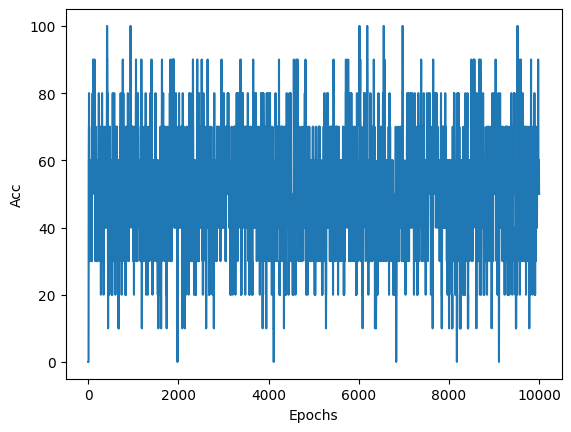

In [6]:
# Définition de l'agent
agent = Agent1(
    model=model_ML,
    all_outcomes= env_test1.get_outcomes(), # L'agent doit connaitre les outcomes possible
    all_actions= env_test1.get_actions(), # Ainsi que les actions
    tokenizer=tokenizer,
    optimizer=optimizer,
    loss_func=loss_func)

# Pour la permière fois, le robot n'a pas d'observation donc d'outcome de l'environement
outcome = None

# Pour voir les performances de l'agent
history_good = []
pourcent_by_10 = []

# Nous lancons 30 intérations pour voir comment se débrouille l'agent
for i in range(10000):
    print(f"=======================\033[0;32m iteration {i} \033[0m=======================")
    action, predi = agent.action(outcome, fit=True, validate_loader=validate_loader)
    outcome = env_test1.outcome(action)
    history_good.append(outcome == predi)
    pourcent_by_10.append(sum(history_good[-10:]) * 10 if len(history_good) >= 10 else 0)
    print(f"Action choisie : {action} \033[0;34m pourcentage de réussite sur les 10 dernier try {pourcent_by_10[-1]} \033[0m")
    print("\n")

see_evolued_acc(pourcent_by_10)

# Résultat
L'agent n'arrive pas a obtenir de bonne prédiction, sauf si il fait la même action qu'avant. En effet en regardant la loss du modèl, nous pouvons deviner que le modèl apprands très bien quand on lui donne 'a' => 'x'. Mais quand il va croiser 'b' => 'y' il va alors remodifier ses poids pour ne plus tenir compte du nouveau jeu de donné.
Donc l'agent n'aura jamais mieux que 0.5 d'accuracie.

# Solution
Pour palier a ce problème, il faut que l'agent puisse s'entrainner avec tout les cas possible de l'environement. Dans notre cas (env1) il faut lui donner :
- 'a' => 'x'
- 'b' => 'y'

Une fois entrainer sur ce jeu de donnée, l'intuition est qu'il aura 1 d'accuracie.

# Exemple avec une chaine d'interaction
Contrairement à la méthode précédente, ici nous allons constitué une chaine d'interaction que l'agent fait en amont. Ici nous allons présenter tout les cas possible c'est à dire :

- 'a' => 'x'
- 'b' => 'y'


liste hidden init [10, 5]
Epoch 1/10, Accuracy: 0.5
Epoch 2/10, Accuracy: 0.5
Epoch 3/10, Accuracy: 0.5
Epoch 4/10, Accuracy: 1.0
Epoch 5/10, Accuracy: 1.0
Epoch 6/10, Accuracy: 0.5
Epoch 7/10, Accuracy: 0.5
Epoch 8/10, Accuracy: 1.0
Epoch 9/10, Accuracy: 1.0
Epoch 10/10, Accuracy: 1.0


/tmp/ipykernel_6800/971051790.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float).to(device)
/tmp/ipykernel_6800/971051790.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


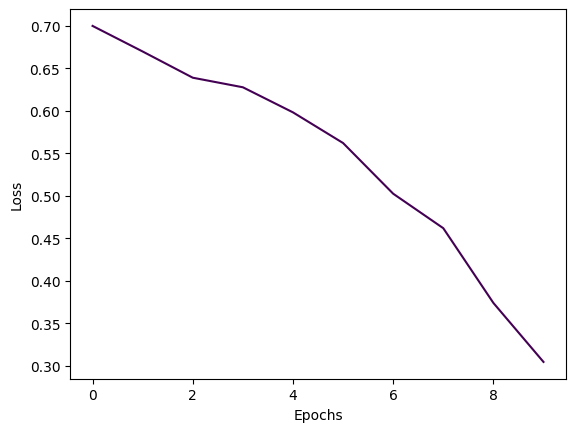

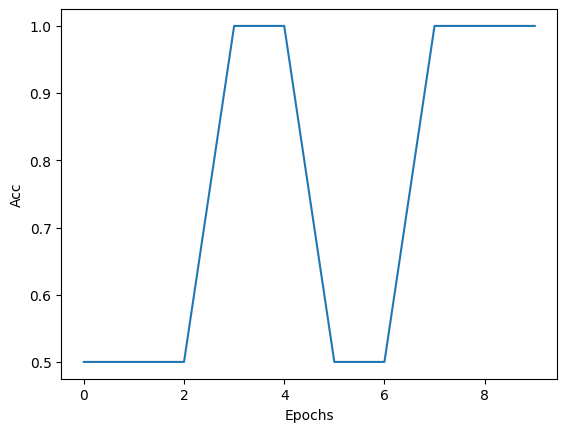

In [7]:
env_test2 = env1()
model_ML = DeepNetwork(hidden_size=[10, 5], input_size=1, output_size=2)
optimizer = torch.optim.Adam(model_ML.parameters(), lr=1e-1, weight_decay=1e-2)
loss_func = nn.CrossEntropyLoss()
tokenizer = SimpleTokenizerV1(create_dico_numerate_word(env_test2.get_outcomes() + env_test2.get_actions()))

x_train = [['a'], ['b']]
x_train = [tokenizer.encode(x) for x in x_train]
y_train = ['x', 'y']
y_train = tokenizer.encode(y_train)

x_train = torch.tensor(x_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.int64).to(device)
x_test = x_train
y_test = y_train

# Transforme y_fit en one hot
# Comme vue précédament, notre sortie est un vecteur qui donne des probabilié
# pour chaque dimension. Nous devons donc associé un vecteur a chaque outcome.
# Exemple :
# outcome = x
# encode('x') = 1
# one hot(1) = 01
# 
# outcome = y
# encode('y') = 0
# one hot(0) = 10
y_train = torch.nn.functional.one_hot(y_train, len(env_test2.get_outcomes())).to(torch.float)

x_test = torch.tensor(x_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

data_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train),
    batch_size=32, shuffle=True
)

validate_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test, y_test),
    batch_size=32, shuffle=False
)

bast_acc, best_model, all_acc, all_loss = train_with_batch(model=model_ML,
                train_loader=data_loader,
                validate_loader=validate_loader,
                optimizer=optimizer,
                loss_func=loss_func,
                nb_epochs=10,
                print_=True
            )
see_evolued_loss([all_loss])
see_evolued_acc(all_acc)

# test model with each action
# for act in env_test2.get_actions():
#     action = tokenizer.encode([act])
#     x = model_ML(torch.tensor(action, dtype=torch.float).to(device))
#     print(f'Action: {act} Prediction: {x}, pour la séquence {torch.tensor(action, dtype=torch.float)}')
#     print(f'decode : {torch.argmax(x, dim=0).item()} {tokenizer.decode(torch.argmax(x, dim=0).item())}')

In [8]:
agent_test2 = Agent1(
    model=model_ML,
    all_outcomes= env_test2.get_outcomes(),
    all_actions= env_test2.get_actions(),
    tokenizer=tokenizer,
    optimizer=None,
    loss_func=None)

history_good = []
pourcent_by_10 = []
outcome = None
for i in range(20):
    print(f"=======================\033[0;32m iteration {i} \033[0m=======================")
    action, predi = agent_test2.action(outcome, False)
    outcome = env_test2.outcome(action)
    history_good.append(outcome == predi)
    pourcent_by_10.append(sum(history_good[-10:]) * 10 if len(history_good) >= 10 else 0)
    print(f'action {action} predi {predi} outcome {outcome}')
    print(f"Action choisie : {action} \033[0;34m{pourcent_by_10[-1]} \033[0m")
    print("\n\n")
    

======================= iteration 0 =======================
Action de base : a Prediction: x
action a predi x outcome x
Action choisie : a 0 



======================= iteration 1 =======================
Action: a, Prediction: x, Outcome: x,  Satisfaction: True 
action b predi y outcome y
Action choisie : b 0 



======================= iteration 2 =======================
Action: b, Prediction: y, Outcome: y,  Satisfaction: True 
action b predi y outcome y
Action choisie : b 0 



======================= iteration 3 =======================
Action: b, Prediction: y, Outcome: y,  Satisfaction: True 
action b predi y outcome y
Action choisie : b 0 



======================= iteration 4 =======================
Action: b, Prediction: y, Outcome: y,  Satisfaction: True 
action a predi x outcome x
Action choisie : a 0 



======================= iteration 5 =======================
Action: a, Prediction: x, Outcome: x,  Satisfaction: True 
action b predi y outcome y
Action choisie : b 0 





# Résultat
Ici nous résultats sont comme nous l'attendions, de 100%. Le modèl a put voir tout les cas possible et peut donc prédire pour chaque action

# Et notre agent dans tout ca ?
On vient de montrer qu'il est nécésaire d'avoir un jeu de donné suffisament grands pour réussir a correctement prédire le prochain feedback. Sur un environement simple où le feedback ne depends que de l'action, on peut avoir un jeu de donnée qui contient toutes les actions et le feedback correspondant.

Cela ne corresponds pas au concepte du developpemental, nous aimerions que le comportement émerge de la suite de ces interactions que l'agent aura lui même choisit. Une idée pour remettre aux cente l'emergence d'un bon comportement petit à petit, est de réentrainer le modèle a chaque mauvaise prédiction.

# L'agent qui met a jour son modèl


In [9]:
class Agent1bonus:
    def __init__(self, model, all_outcomes, all_actions, tokenizer, optimizer=None, loss_func=None):
        """ 
        Création de l'agent.
        
        - self._action : action précédente
        - self._predicted_outcome : prédiction de l'outcome précédent
        """
        self._action = None
        self._predicted_outcome = None
        self._model = model
        self._otimizer = optimizer
        self._loss_func = loss_func
        self._tokenizer:SimpleTokenizerV1 = tokenizer
        self._all_outcomes = all_outcomes
        self._all_actions = all_actions
        self._history_act = []
        self._history_fb = []

    def fit(self, actions:list, outcomes:list, validate_loader=None):
        """
        Fonction d'entrainement de l'agent
        """
        actions = [[self._tokenizer.encode(act)] for act in actions]
        outcomes = self._tokenizer.encode(outcomes)
        print("je dois fit avec :")
        print(actions)
        print(outcomes)
        if isinstance(self._model, torch.nn.Module):
            self._model.train()
            actions = torch.tensor(actions, dtype=torch.float).to(device)
            outcomes = torch.tensor(outcomes, dtype=torch.long).to(device)
            outcomes = torch.nn.functional.one_hot(outcomes, 
                num_classes=len(self._all_outcomes) # On précise le nombre d'ouctomes possible 
                ).to(torch.float)
            
            data_loader = torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(actions, outcomes),
                batch_size=32, shuffle=True
            )

            train_with_batch(model=self._model, 
                    train_loader=data_loader,
                    optimizer=self._otimizer,
                    loss_func=self._loss_func,
                    nb_epochs=10,
                    validate_loader=validate_loader,
                    print_=True)
        else :# Si le model n'est pas un model pytorch
            raise Exception('Not implemented')
            self._model.fit(action, outcome)
            pass
       

    def predict(self, action):
        """
        Funciton de prédiction
        """
        action = self._tokenizer.encode(action)
        if isinstance(self._model, torch.nn.Module): # Si le model est un model pytorch
            self._model.eval() # On peut le passer en mode evaluation
            # On prépare notre jeu de donnée, qui consite en 
            # la dernière action et l'outcome de la dernière interaction 
            action = torch.tensor([action], dtype=torch.float).to(device)
            x = self._model(action)
            x = torch.argmax(x, dim=0).item()

        else: # Si le model n'est pas un model pytorch
            raise Exception('Not implemented')
            x=self._model.predict(action)
        
        return self._tokenizer.decode(x)

    def action(self, outcome, fit=True, validate_loader=None):
        """ 
        Fonction qui choisit l'action a faire en fonction de la dernière \
        intéraction avec l'environnement. \n
        C'est ici que nous allons implémenter un mécanisme de ML \
        pour choisir la prochaine action.

        :param: **outcome** feedback de la dernière intéraction avec l'environnement

        :return: **action** action à effectuer
        """
        if self._action is not None:
            self._history_fb.append(outcome)
            print(f"Action: {self._action}, Prediction: {self._predicted_outcome}, Outcome: {outcome}, " 
                  f"\033[0;31m Satisfaction: {self._predicted_outcome == outcome} \033[0m")
            # Nous entrainons le model sur la dernière action et son outcome
            if self._predicted_outcome != outcome:
                self.fit(self._history_act, self._history_fb, validate_loader)
            # Nous faisons une prédiction sur une action aléatoire
            self._action = np.random.choice(self._all_actions)
            self._history_act.append(self._action)
            self._predicted_outcome = self.predict(self._action)
        else:
            # Au début de la vie de l'agent, nous prennons la première action possible
            self._action = self._all_actions[0]
            self._history_act.append(self._action)
            self._predicted_outcome = self.predict(self._action)
            print(f"Action de base : {self._action} Prediction: {self._predicted_outcome}")
        
        return self._action, self._predicted_outcome

In [10]:
env_test2 = env1()
model_ML = DeepNetwork(hidden_size=[10, 5], input_size=1, output_size=2)
optimizer = torch.optim.Adam(model_ML.parameters(), lr=1e-1, weight_decay=1e-2)
loss_func = nn.CrossEntropyLoss()
tokenizer = SimpleTokenizerV1(create_dico_numerate_word(env_test2.get_outcomes() + env_test2.get_actions()))

agent_test2 = Agent1bonus(
    model=model_ML,
    all_outcomes= env_test2.get_outcomes(),
    all_actions= env_test2.get_actions(),
    tokenizer=tokenizer,
    optimizer=optimizer,
    loss_func=loss_func)

history_good = []
pourcent_by_10 = []
outcome = None
for i in range(100):
    print(f"=======================\033[0;32m iteration {i} \033[0m=======================")
    action, predi = agent_test2.action(outcome, False)
    outcome = env_test2.outcome(action)
    history_good.append(outcome == predi)
    pourcent_by_10.append(sum(history_good[-10:]) * 10 if len(history_good) >= 10 else 0)
    print(f'action {action} predi {predi} outcome {outcome}')
    print(f"Action choisie : {action} \033[0;34m{pourcent_by_10[-1]} \033[0m")
    print("\n\n")
    

liste hidden init [10, 5]
======================= iteration 0 =======================
Action de base : a Prediction: x
action a predi x outcome x
Action choisie : a 0 



======================= iteration 1 =======================
Action: a, Prediction: x, Outcome: x,  Satisfaction: True 
action a predi x outcome x
Action choisie : a 0 



======================= iteration 2 =======================
Action: a, Prediction: x, Outcome: x,  Satisfaction: True 
action a predi x outcome x
Action choisie : a 0 



======================= iteration 3 =======================
Action: a, Prediction: x, Outcome: x,  Satisfaction: True 
action a predi x outcome x
Action choisie : a 0 



======================= iteration 4 =======================
Action: a, Prediction: x, Outcome: x,  Satisfaction: True 
action a predi x outcome x
Action choisie : a 0 



======================= iteration 5 =======================
Action: a, Prediction: x, Outcome: x,  Satisfaction: True 
action a predi x outcome x

# Résultat
Sur un environement simple, dès la première ou deuxième mauvaise prédiction, le modèls s'entraine de manière suffisante pour prédire la suite.

Testons sur un environement plus complexe !

In [11]:
env_test2 = env6Str()
model_ML = DeepNetwork(hidden_size=[10, 5], input_size=1, output_size=2)
optimizer = torch.optim.Adam(model_ML.parameters(), lr=1e-1, weight_decay=1e-2)
loss_func = nn.CrossEntropyLoss()
tokenizer = SimpleTokenizerV1(create_dico_numerate_word(env_test2.get_outcomes() + env_test2.get_actions()))

agent_test2 = Agent1bonus(
    model=model_ML,
    all_outcomes= env_test2.get_outcomes(),
    all_actions= env_test2.get_actions(),
    tokenizer=tokenizer,
    optimizer=optimizer,
    loss_func=loss_func)

history_good = []
pourcent_by_10 = []
outcome = None
for i in range(100):
    print(f"=======================\033[0;32m iteration {i} \033[0m=======================")
    action, predi = agent_test2.action(outcome, False)
    outcome = env_test2.outcome(action)
    history_good.append(outcome == predi)
    pourcent_by_10.append(sum(history_good[-10:]) * 10 if len(history_good) >= 10 else 0)
    print(f'action {action} predi {predi} outcome {outcome}')
    print(f"Action choisie : {action} \033[0;34m{pourcent_by_10[-1]} \033[0m")
    print("\n\n")
    

liste hidden init [10, 5]
======================= iteration 0 =======================
Action de base : a Prediction: x
action a predi x outcome y
Action choisie : a 0 



======================= iteration 1 =======================
Action: a, Prediction: x, Outcome: y,  Satisfaction: False 
je dois fit avec :
[[2]]
[1]
Epoch 1/10, Loss: 0.8333
Epoch 2/10, Loss: 0.5426
Epoch 3/10, Loss: 0.3442
Epoch 4/10, Loss: 0.1602
Epoch 5/10, Loss: 0.0454
Epoch 6/10, Loss: 0.0070
Epoch 7/10, Loss: 0.0006
Epoch 8/10, Loss: 0.0001
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
action b predi y outcome x
Action choisie : b 0 



======================= iteration 2 =======================
Action: b, Prediction: y, Outcome: x,  Satisfaction: False 
je dois fit avec :
[[2], [3]]
[1, 0]
Epoch 1/10, Loss: 10.1658
Epoch 2/10, Loss: 8.3056
Epoch 3/10, Loss: 6.1101
Epoch 4/10, Loss: 4.0665
Epoch 5/10, Loss: 2.4226
Epoch 6/10, Loss: 1.1426
Epoch 7/10, Loss: 0.7927
Epoch 8/10, Loss: 0.7663
Epoch 9/10, Loss: 0

# Résultat
De manière évidante l'agent n'arrive pas a prédire corectement le prochain feedback. En effet l'environnement est plus complexe et dépand des interactions passé. Nous verrons avec l'agent 4 comment essayer de résoudre se problème.